# Filecoin gas analysis - plots and conclusions

### Maria Silva

*Jan 2022*

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## 1. Load data


In [2]:
raw_df = pd.read_csv("./data/derived_gas_outputs_minutes.csv", index_col=0)

raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34273 entries, 0 to 34272
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   timestamp                  34273 non-null  object 
 1   mean_gas_fee_cap           34273 non-null  float64
 2   mean_gas_premium           34273 non-null  float64
 3   mean_gas_limit             34273 non-null  float64
 4   mean_gas_used              34273 non-null  float64
 5   mean_parent_base_fee       34273 non-null  float64
 6   mean_base_fee_burn         34273 non-null  float64
 7   mean_over_estimation_burn  34273 non-null  float64
 8   mean_gas_refund            34273 non-null  float64
 9   mean_gas_burned            34273 non-null  float64
dtypes: float64(9), object(1)
memory usage: 2.9+ MB


**Transformations:**

1. Convert timestamps to days (easier plotting)
2. Convert attoFIL to nanoFIL:
    - 1 FIL = 1E18 attoFIL
    - 1 FIL = 1E9 nanoFIL
    - 1 attoFIL = 1E-9 nanoFIL
3. Convert all GasUnit to million GasUnits (1 GasUnit = 1E-6 million GasUnits)
4. Compute the `mean_gas_estimation_error` as the difference between `mean_gas_limit` and `mean_gas_used`. The unit of this variable is million GasUnit.
5. Compute the overestimation penalty (in million GasUnits) as the difference between `mean_gas_estimation_error` and `mean_gas_refund`. The rational for this is that a proportion of the difference between the gas limit and the gas used is burned as an overestimation penalty, while the remaining is returned to the message sender.

In [3]:
# Copy df
data_df = raw_df.copy(deep=True)

# Get days
data_df["timestamp"] = pd.to_datetime(data_df["timestamp"])
data_df["day"] = data_df["timestamp"].dt.day.astype("str")

# Convert attoFIL to nanoFIL
data_df["mean_gas_fee_cap"] = data_df["mean_gas_fee_cap"]*1E-9 
data_df["mean_gas_premium"] = data_df["mean_gas_premium"]*1E-9 
data_df["mean_parent_base_fee"] = data_df["mean_parent_base_fee"]*1E-9 
data_df["mean_base_fee_burn"] = data_df["mean_base_fee_burn"]*1E-9 
data_df["mean_over_estimation_burn"] = data_df["mean_over_estimation_burn"]*1E-9 

# Convert GasUnit to million GasUnit
data_df["mean_gas_limit"] = data_df["mean_gas_limit"]*1E-6 
data_df["mean_gas_used"] = data_df["mean_gas_used"]*1E-6 
data_df["mean_gas_refund"] = data_df["mean_gas_refund"]*1E-6
data_df["mean_gas_burned"] = data_df["mean_gas_burned"]*1E-6

# Get mean gas estimation error (in million GasUnit)
data_df["mean_gas_estimation_error"] = data_df["mean_gas_limit"] - data_df["mean_gas_used"]

# Get mean over-estimation penalty in million GasUnits
data_df["mean_over_estimation_penalty"] = (
    data_df["mean_gas_estimation_error"] - data_df["mean_gas_refund"]
)

data_df.describe().T

,count,mean,std,min,25%,50%,75%,max
mean_gas_fee_cap,34273.0,9.332010e+00,4.525614e+00,5.746347e-01,6.363798e+00,8.880672e+00,1.162421e+01,2.011381e+02
mean_gas_premium,34273.0,1.497482e-03,8.109318e-03,8.200945e-05,1.114223e-04,3.657263e-04,8.884868e-04,7.990103e-01
mean_gas_limit,34273.0,3.989642e+01,4.347213e+00,2.428070e+01,3.779839e+01,3.932166e+01,4.124140e+01,1.974523e+02
mean_gas_used,34273.0,3.226650e+01,2.210611e+00,1.408784e+01,3.087624e+01,3.202065e+01,3.338107e+01,5.744429e+01
mean_parent_base_fee,34273.0,6.106657e-01,5.208931e-01,1.000000e-07,1.999907e-01,5.404110e-01,9.484614e-01,6.147238e+00
mean_base_fee_burn,34273.0,1.944904e+07,1.674395e+07,2.016133e+00,6.337284e+06,1.728121e+07,3.055251e+07,1.944513e+08
mean_over_estimation_burn,34273.0,1.086866e+06,1.332562e+06,7.553782e-02,2.936702e+05,8.453976e+05,1.536348e+06,9.875548e+07
mean_gas_refund,34273.0,5.800183e+00,4.845310e-01,2.687929e+00,5.491961e+00,5.752933e+00,6.052404e+00,1.029855e+01
mean_gas_burned,34273.0,1.829740e+00,3.401566e+00,6.165379e-01,1.240027e+00,1.498004e+00,1.892188e+00,1.746765e+02
mean_gas_estimation_error,34273.0,7.629922e+00,3.425578e+00,4.114721e+00,6.810394e+00,7.284161e+00,7.909892e+00,1.773645e+02


## 2. Base fee

The base fee is an important component of the gas fee mechanism. In the transaction fee paid by participants in the Filecoin network, a big part is controlled by the base fee, which we can observe from the formula:

```
GasUsage * BaseFee FIL (gas burned) + GasLimit * GasPremium FIL (miner's reward) + OverEstimationBurn * BaseFee FIL (gas burned due to gas estimation errors)
```

In this dataset, we have the Parent base fee, which is the base fee applied to the parent epoch. So, let's take a deeper look at this variable and how it relates to other variables in the dataset.

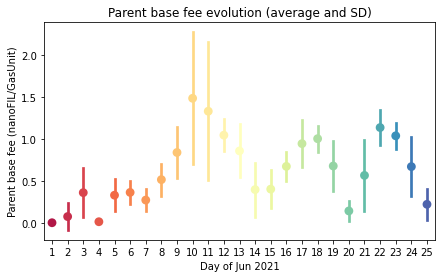

In [4]:
plt.figure(figsize=(7,4))
sns.pointplot(x="day", y="mean_parent_base_fee", data=data_df, palette="Spectral", ci="sd")

plt.xlabel("Day of Jun 2021")
plt.ylabel("Parent base fee (nanoFIL/GasUnit)")
plt.title("Parent base fee evolution (average and SD)")
plt.show()

It is interesting to observe that there is a some flutuation of the base fee during the month of June 2021. Interestingly, the fees start very small and, after day 9, they quickly increase to the highest values observed in June. After this, they experience some ups and downs.

Now, let's look into the gas consumption.

In [5]:
data_df[["mean_parent_base_fee", "mean_gas_used"]].corr()

,mean_parent_base_fee,mean_gas_used
mean_parent_base_fee,1.000000,0.119276
mean_gas_used,0.119276,1.000000


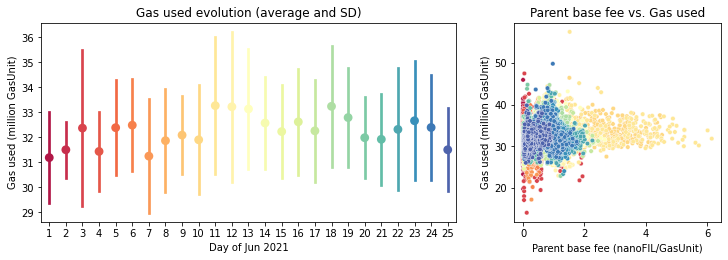

In [6]:
fig = plt.figure(figsize=(10, 3.5), constrained_layout=True)
spec = fig.add_gridspec(1, 3, wspace=0.1)

ax0 = fig.add_subplot(spec[0, :2])
sns.pointplot(x="day", y="mean_gas_used", data=data_df, palette="Spectral", ci="sd", ax=ax0)
ax0.set_xlabel("Day of Jun 2021")
ax0.set_ylabel("Gas used (million GasUnit)")
ax0.set_title("Gas used evolution (average and SD)")


ax1 = fig.add_subplot(spec[0, 2])
sns.scatterplot(x="mean_parent_base_fee", y="mean_gas_used", hue="day", data=data_df, 
                palette="Spectral", legend=False, s=20, ax=ax1)
ax1.set_xlabel("Parent base fee (nanoFIL/GasUnit)")
ax1.set_ylabel("Gas used (million GasUnit)")
ax1.set_title("Parent base fee vs. Gas used")
plt.show()

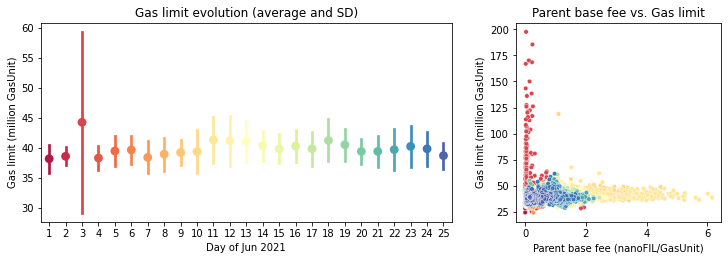

In [7]:
fig = plt.figure(figsize=(10, 3.5), constrained_layout=True)
spec = fig.add_gridspec(1, 3, wspace=0.1)

ax0 = fig.add_subplot(spec[0, :2])
sns.pointplot(x="day", y="mean_gas_limit", data=data_df, palette="Spectral", ci="sd", ax=ax0)
ax0.set_xlabel("Day of Jun 2021")
ax0.set_ylabel("Gas limit (million GasUnit)")
ax0.set_title("Gas limit evolution (average and SD)")


ax1 = fig.add_subplot(spec[0, 2])
sns.scatterplot(x="mean_parent_base_fee", y="mean_gas_limit", hue="day", data=data_df, 
                palette="Spectral", legend=False, s=20, ax=ax1)
ax1.set_xlabel("Parent base fee (nanoFIL/GasUnit)")
ax1.set_ylabel("Gas limit (million GasUnit)")
ax1.set_title("Parent base fee vs. Gas limit")
plt.show()

## 3. Gas cap and and Premium fee

How we start to analyse how users responded to these fluctuations in the base fee. Have they adapted to the parent base fee and changed their gas caps acordingly? If yes, we would expect to see a high correlation between the base fee and the gas cap. We would also expect to see a stabilization of premium fee.

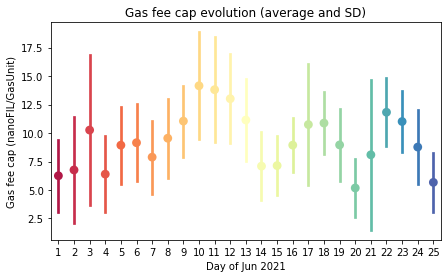

In [8]:
plt.figure(figsize=(7,4))
sns.pointplot(x="day", y="mean_gas_fee_cap", data=data_df, palette="Spectral", ci="sd")

plt.xlabel("Day of Jun 2021")
plt.ylabel("Gas fee cap (nanoFIL/GasUnit)")
plt.title("Gas fee cap evolution (average and SD)")
plt.show()

Looking at the gas fee caps per day, we see a similiar trend to the one observed in the parent base fees. In other words, we see the same up and down fluctuations after 10th. However, in the beggining of the month, the relationship is not as clear. Let's take a closer look at their relationship in the next plot.

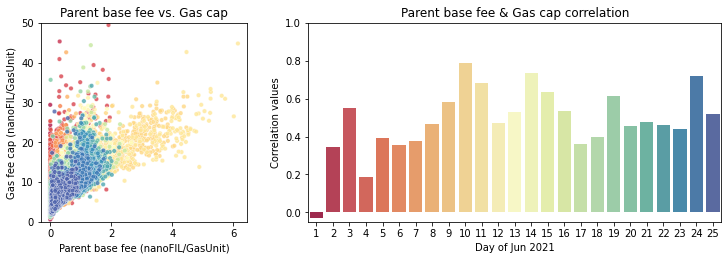

In [9]:
fig = plt.figure(figsize=(10, 3.5), constrained_layout=True)
spec = fig.add_gridspec(1, 3, wspace=0.1)

ax0 = fig.add_subplot(spec[0, 0])
sns.scatterplot(x="mean_parent_base_fee", y="mean_gas_fee_cap", hue="day", ax=ax0,
                data=data_df, alpha=0.8, palette="Spectral", s=20, legend=False)
ax0.set_ylim(0,50)
ax0.set_xlabel("Parent base fee (nanoFIL/GasUnit)")
ax0.set_ylabel("Gas fee cap (nanoFIL/GasUnit)")
ax0.set_title("Parent base fee vs. Gas cap")


ax1 = fig.add_subplot(spec[0, 1:])
corr_df = (
    data_df[["day", "mean_parent_base_fee", "mean_gas_fee_cap"]]
    .groupby("day")
    .corr()
    .reset_index()
)
corr_df["day"] = corr_df["day"].astype("int")
corr_df = (
    corr_df[corr_df["level_1"] == "mean_gas_fee_cap"]
    .sort_values("day")
    [["day", "mean_parent_base_fee"]]
    
)
sns.barplot(x="day", y="mean_parent_base_fee", data=corr_df, ci=None, palette="Spectral", ax=ax1)
ax1.set_ylim(-0.05, 1)
ax1.set_xlabel("Day of Jun 2021")
ax1.set_ylabel("Correlation values")
ax1.set_title("Parent base fee & Gas cap correlation")


plt.show()

In [10]:
data_df[["mean_parent_base_fee", "mean_gas_fee_cap"]].corr()

,mean_parent_base_fee,mean_gas_fee_cap
mean_parent_base_fee,1.000000,0.642602
mean_gas_fee_cap,0.642602,1.000000


We see a overall correlation of 0.64, which indicates that network users do try to follow the parent base fee when setting their gas caps. However, we also observe some level of resistence. Particularly, the correlation by day is highest when the base fee is also high.

Now, let's take a look at the Gas premium fees. We see some outliers on the 3rd and 7th of June, however, excluding those, premium fee has remained more or less stable during June 2021.

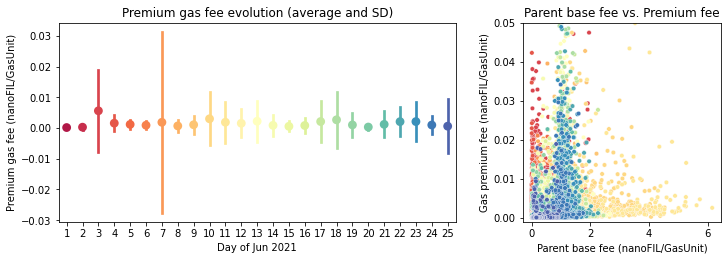

In [11]:
fig = plt.figure(figsize=(10, 3.5), constrained_layout=True)
spec = fig.add_gridspec(1, 3, wspace=0.1)

ax0 = fig.add_subplot(spec[0, :2])
sns.pointplot(x="day", y="mean_gas_premium", data=data_df, palette="Spectral", ci="sd", ax=ax0)
ax0.set_xlabel("Day of Jun 2021")
ax0.set_ylabel("Premium gas fee (nanoFIL/GasUnit)")
ax0.set_title("Premium gas fee evolution (average and SD)")


ax1 = fig.add_subplot(spec[0, 2])
sns.scatterplot(x="mean_parent_base_fee", y="mean_gas_premium", hue="day", data=data_df, 
                palette="Spectral", legend=False, s=20)
ax1.set_ylim(-0.001, 0.05)
ax1.set_xlabel("Parent base fee (nanoFIL/GasUnit)")
ax1.set_ylabel("Gas premium fee (nanoFIL/GasUnit)")
ax1.set_title("Parent base fee vs. Premium fee")
plt.show()

In addition, the premium fee is not strongly correlated with the parent base fee, which indicates that changes in the base fee are not coupled with either positive nor negative changes in the premium fee.

In [12]:
data_df[["mean_parent_base_fee", "mean_gas_premium"]].corr()

,mean_parent_base_fee,mean_gas_premium
mean_parent_base_fee,1.000000,0.106742
mean_gas_premium,0.106742,1.000000


In conclusion, users seem to loosely adjust their fee caps with changes in the base fee. However, this change is not transfered to the premium fees. Particularly, the premium fee is not correlated with the base fee, meaning that in times of high congestion the average user does not increase the miner rewards to make sure that their transaction goes through. In these situations, we tend to see an increase in the fee caps, but these only cover the increase in the base fees. 

This is a very interesting phenomemon we should explore in more detail. It would be interesting to see if this trend is maintained on all message types (which would require a split of gas fee per message type). In particular, it would be interesting to see if the trend is maintained in two distinct groups of messages - proof messages and 
deals messages. Since the first are mostly sent by miner while the second are aggreements between miners and clients, we may see different dynamics in these two groups.

It would be also interesting to investigate whether this trend is consistent through time. It could be that this trend only happened in the start of network and, more recently, with more people joining the network, a new dynamic has emerged. For this, we would need to collect data for a longer time period.

## 3. Gas estimation and overestimation penalty

Another interesting mechanism of the Filecoin gas fees is the overestimation penalty. This fee depends on the diference between the estimated gas limit and the actual gas used by the message (the higher the diference, the more FIL is burned). 

The goal of this penalty is to force the users of the network to estimate their gas comsumption correctly. But why is this important? Miners can only add new message to their block up to a a threshold of the gas and to check whether thier block is passing this threshold, they add all the gas limits of the transactions they want to include in the block. Therefore, the estimated gas limit ocupies space in each block and overestimations leads to a loss of gas that could have been used in other transactions.

Let's start by analysing the evolution of the of the gas estimation error and and overestimation penalty.

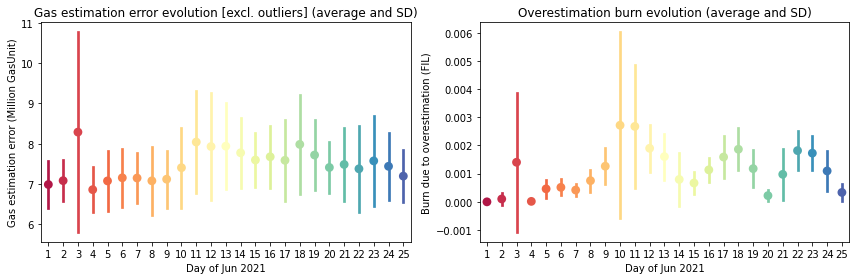

In [13]:
temp_df = data_df.copy(deep=True)
temp_df["mean_over_estimation_burn"] = temp_df["mean_over_estimation_burn"]*1E-9

fig, axs = plt.subplots(1,2, figsize=(12,4))

sns.pointplot(x="day", y="mean_gas_estimation_error", data=temp_df[temp_df["mean_gas_estimation_error"]<25],
              palette="Spectral", ci="sd", ax=axs[0])
axs[0].set_xlabel("Day of Jun 2021")
axs[0].set_ylabel("Gas estimation error (Million GasUnit)")
axs[0].set_title("Gas estimation error evolution [excl. outliers] (average and SD)")

sns.pointplot(x="day", y="mean_over_estimation_burn", data=temp_df, palette="Spectral", ci="sd", ax=axs[1])
axs[1].set_xlabel("Day of Jun 2021")
axs[1].set_ylabel("Burn due to overestimation (FIL)")
axs[1].set_title("Overestimation burn evolution (average and SD)")

plt.tight_layout()
plt.show()

From these plots, we observe daily fluctuations similiar to the ones experienced with the base fee. Concretly, on the 3rd, 11th, 18th, and 23rd of June, there is an increase in gas estimation errors and, consequently, on the amount of FIL burned due to overestimation.

This effect was specially felt on the 3rd, where a significant number of large estimation errors skewed the average of that day. This was the day when larger than normal premiums were paid to miners and when we started to observe a sustained increase in the base fee. From the data we have, it is not clear what happened in that day. However, one possible explaination could an an influx of new and/or inexperienced users to the network that increased the number of messages being sent and, at the same time, were overestimating their gas limit. In order to fully understand this effect, one could analyse the how the number of new actors and active actors per day evolved during this month. Looking at the total number of actors and its distribution by actor type (e.g. miner, token holder, client, etc.), could give us an idea of what was causing this phenomenon.

The other time where we see very high overestimation burn amounts is around the 11th of June. However, looking at both the base fees and the estimation errors during this time, we conclude that the high overestimation burn amount was mostly caused by the increase in the base fee and not by the actual overestimation errors. The next plot better showcases this. On the dark red points (i.e., day 3), we see high overestimation penalties and low base fees, while, on the yellow points (i.e., day 10th), we see "normal" overestimation penalties and high base fees.

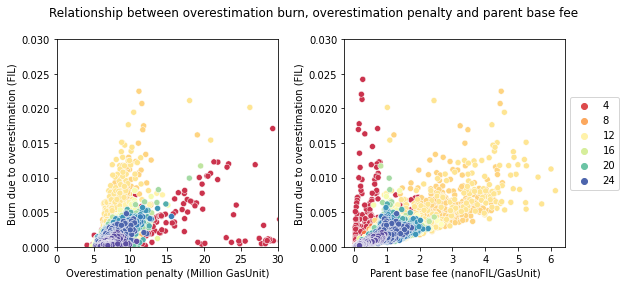

In [14]:
temp_df = data_df.copy(deep=True)
temp_df["mean_over_estimation_burn"] = temp_df["mean_over_estimation_burn"]*1E-9
temp_df["day"]= temp_df["day"].astype("int")

fig, axs = plt.subplots(1,2, figsize=(8.8,4))

sns.scatterplot(x="mean_gas_estimation_error", y="mean_over_estimation_burn",
                hue="day", data=temp_df, palette="Spectral", legend=False, ax=axs[0])
axs[0].set_xlim(0,30)
axs[0].set_ylim(0,0.03)
axs[0].set_xlabel("Overestimation penalty (Million GasUnit)")
axs[0].set_ylabel("Burn due to overestimation (FIL)")

sns.scatterplot(x="mean_parent_base_fee", y="mean_over_estimation_burn",
                hue="day", data=temp_df, palette="Spectral", ax=axs[1])
axs[1].set_ylim(0,0.03)
axs[1].set_xlabel("Parent base fee (nanoFIL/GasUnit)")
axs[1].set_ylabel("Burn due to overestimation (FIL)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.suptitle("Relationship between overestimation burn, overestimation penalty and parent base fee")
plt.tight_layout()
plt.show()

## 4. Data inconsistencies

Something wrong with either the cap fee or the premium fee

In [15]:
data_df[["mean_parent_base_fee", "mean_gas_fee_cap", "mean_gas_premium"]].corr()

,mean_parent_base_fee,mean_gas_fee_cap,mean_gas_premium
mean_parent_base_fee,1.000000,0.642602,0.106742
mean_gas_fee_cap,0.642602,1.000000,0.068521
mean_gas_premium,0.106742,0.068521,1.000000


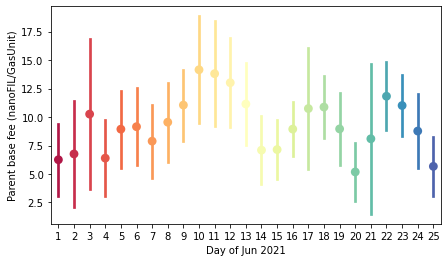

In [16]:
temp_df = data_df.copy(deep=True)
temp_df["mean_base_fee"] = temp_df["mean_gas_fee_cap"]- temp_df["mean_gas_premium"]

plt.figure(figsize=(7,4))
sns.pointplot(x="day", y="mean_base_fee", data=temp_df, palette="Spectral", ci="sd")
plt.xlabel("Day of Jun 2021")
plt.ylabel("Parent base fee (nanoFIL/GasUnit)")
plt.show()

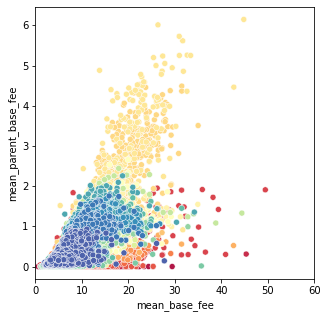

In [17]:
temp_df = data_df.copy(deep=True)
temp_df["mean_base_fee"] = temp_df["mean_gas_fee_cap"]- temp_df["mean_gas_premium"]

plt.figure(figsize=(5,5))
sns.scatterplot(x="mean_base_fee", y="mean_parent_base_fee", hue="day", data=temp_df, 
                palette="Spectral", legend=False)
plt.xlim(0, 60)
plt.show()

In [18]:
temp_df = data_df.copy(deep=True)
temp_df["mean_gas_premium_computed"] = temp_df["mean_gas_fee_cap"]- temp_df["mean_parent_base_fee"]

temp_df[["mean_parent_base_fee", "mean_gas_fee_cap", "mean_gas_premium_computed"]].corr()

,mean_parent_base_fee,mean_gas_fee_cap,mean_gas_premium_computed
mean_parent_base_fee,1.000000,0.642602,0.567069
mean_gas_fee_cap,0.642602,1.000000,0.995496
mean_gas_premium_computed,0.567069,0.995496,1.000000


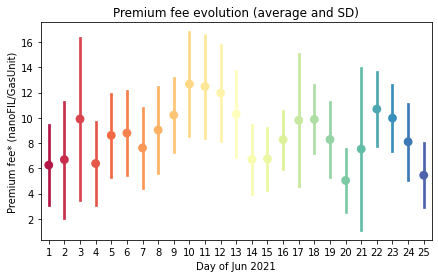

In [19]:
plt.figure(figsize=(7,4))
sns.pointplot(x="day", y="mean_gas_premium_computed", data=temp_df, palette="Spectral", ci="sd")

plt.xlabel("Day of Jun 2021")
plt.ylabel("Premium fee* (nanoFIL/GasUnit)")
plt.title("Premium fee evolution (average and SD)")
plt.show()

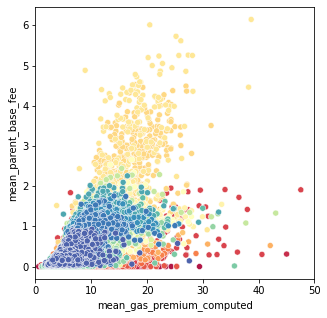

In [20]:
plt.figure(figsize=(5,5))
sns.scatterplot(x="mean_gas_premium_computed", y="mean_parent_base_fee", hue="day", data=temp_df, 
                palette="Spectral", legend=False)
plt.xlim(0, 50)
plt.show()

# Extra plots

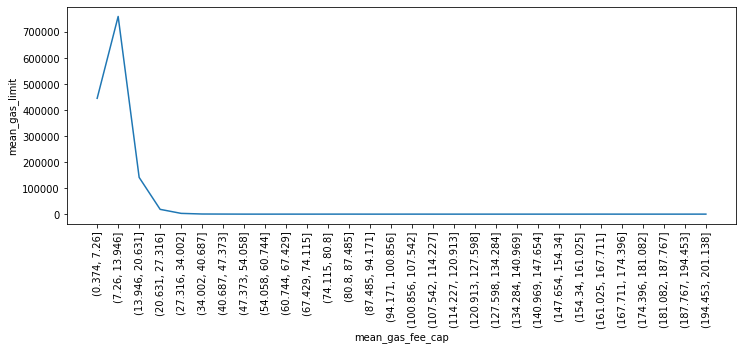

In [21]:
temp_df = data_df.copy(deep=True)
temp_df["mean_gas_fee_cap"] = pd.cut(data_df["mean_gas_fee_cap"], bins=30)

temp_df = (
    temp_df
    .groupby("mean_gas_fee_cap")
    [["mean_gas_limit", "mean_gas_used"]]
    .sum()
    .reset_index()
)
temp_df["mean_gas_fee_cap"] = temp_df["mean_gas_fee_cap"].astype("str")

plt.figure(figsize=(12,4))
sns.lineplot(x="mean_gas_fee_cap", y="mean_gas_limit", data=temp_df)
plt.xticks(rotation=90)
plt.show()

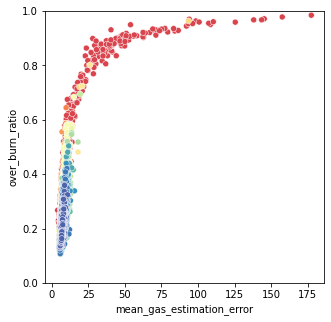

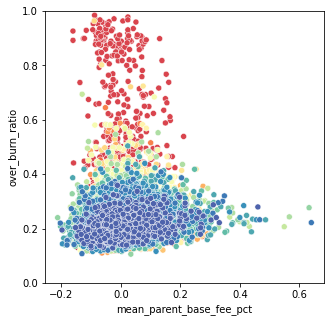

In [22]:
temp_df = data_df.copy(deep=True)
temp_df["over_burn_ratio"] = temp_df["mean_over_estimation_penalty"]/temp_df["mean_gas_estimation_error"]
temp_df["mean_parent_base_fee_pct"] = temp_df["mean_parent_base_fee"].pct_change()

plt.figure(figsize=(5,5))
sns.scatterplot(x="mean_gas_estimation_error", y="over_burn_ratio", hue="day", data=temp_df, 
                palette="Spectral", legend=False)
plt.ylim(0,1)
plt.show()

plt.figure(figsize=(5,5))
sns.scatterplot(x="mean_parent_base_fee_pct", y="over_burn_ratio", hue="day", data=temp_df, 
                palette="Spectral", legend=False)
plt.ylim(0,1)
plt.show()

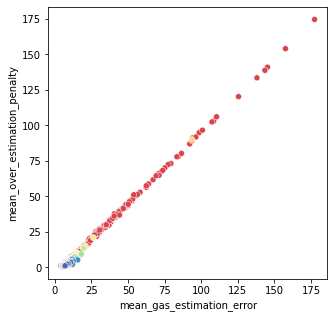

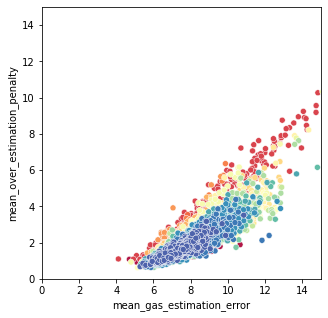

In [23]:
plt.figure(figsize=(5,5))
sns.scatterplot(x="mean_gas_estimation_error", y="mean_over_estimation_penalty", hue="day", data=temp_df, 
                palette="Spectral", legend=False)
plt.show()

plt.figure(figsize=(5,5))
sns.scatterplot(x="mean_gas_estimation_error", y="mean_over_estimation_penalty", hue="day", data=temp_df, 
                palette="Spectral", legend=False)
plt.xlim(0,15)
plt.ylim(0,15)
plt.show()